# Calculating XY model with DMRG
This notebook calculates the ground states of XY model with DMRG methods and compare it with the analytical results of the exactly solvable model XY model

## XY model
The XY model is a spin-1/2 chain with the following Hamiltonian

$$H = J\sum_i S^x_i S^x_{i+1} + S^y_i S^y_{i+1}$$

This can be rewritten in terms of raising and lowering operators of spins

$$H = \frac{J}{2}\sum_i S^+_i S^-_{i+1}+ S^-_i S^+_{i+1}$$

the model can be solved using Jordan-Wigner transformation. The Jordan-Wigner transformation transforms the Hamiltonina into the following form 

$$H = J \sum_k \cos\left(\frac{2\pi k }{N}\right)d^\dagger_k d_k $$

Therefore in the ground state the bands are half-filled. Note that because $J\to -J$ simply flips the band, the ground state of $J>0$ and $J<0$ is the same. For $J >0$ and in thermodynamic limit $N\to\infty$, we have

$$\frac{U}{N} = - \frac{J}{N}\int_{-\pi/2}^{\pi/2}\frac{N dx}{2\pi} \cos(x) = -\frac{J}{\pi} $$
Therefore we have $$\frac{E_{GS}}{N|J|}=\frac{1}{\pi}$$

## Implementation of the XY model

In [1]:
from tenpy.networks.site import SpinSite
from tenpy.networks.mps import MPS
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel
from tenpy.algorithms import dmrg
from tenpy.tools.params import asConfig

In [46]:
from tenpy.networks.site import SpinSite
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel
from tenpy.algorithms import dmrg
from tenpy.tools.params import asConfig

In [47]:
# Implementation using CouplingModel
class XYModel(MPOModel,CouplingModel):
    def __init__(self,model_params):
        model_params = asConfig(model_params,"XYModel") # Convert the dictionary into Config
        L = model_params.get('L',2)
        J = model_params.get('J',1)
        self.J = J
        self.L = L
        bc_MPS = model_params.get('bc_MPS','finite')
        sort_charge = model_params.get('sort_charge',True)
        
        site = SpinSite(S=1/2,conserve='Sz',sort_charge=sort_charge) # We can write the XX and YY as + and -
        bc = 'open' if bc_MPS == 'finite' else 'periodic'
        
        self.lat = Chain(L,site,bc=bc,bc_MPS=bc_MPS) # Initialize a spin chain
        
        CouplingModel.__init__(self,self.lat) # Initialize coupling model
        
        self.add_coupling(0.5*J,0,'Sp',0,'Sm',1,plus_hc=True) # Add coupling terms w/ h.c.
        
        MPOModel.__init__(self,self.lat,self.calc_H_MPO()) # Initialize MPO model with MPO Hamiltonian
        
        

Let's create our model

In [51]:
model_params = dict(L=10,J=2)
model = XYModel(model_params)

We can visualize the model by plotting the lattice

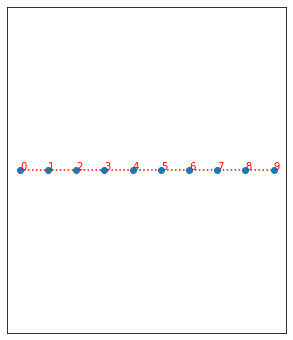

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,6))
ax=plt.gca()
#model.lat.plot_coupling(ax)
model.lat.plot_order(ax,linestyle=':')
#ax.set_aspect('equal')
model.lat.plot_sites(ax)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

We now move on and do some simulations on the chain.
To run dmrg, we need
- A model specifying the Hamiltonian
- A MPS initial state

We will first create a state. We will start with a Neel state 
$$|\uparrow\downarrow\uparrow\downarrow\cdots \uparrow\downarrow\rangle$$
(Note that we cannot start with state with all up or down, because the Hamiltonian is identically zero in that subspace and MPS won't run)

In [53]:
prod_state = ['up','down']*(model.lat.N_sites//2)
psi = MPS.from_product_state(model.lat.mps_sites(),prod_state,bc=model.lat.bc_MPS)
psi

We will use the following configuration:
- The parameter $\mathcal \chi_\text{max}$ specifies the maximum bond dimension used

More can be found here: https://tenpy.readthedocs.io/en/latest/reference/tenpy.algorithms.dmrg.DMRGEngine.html#dmrgengine 

In [39]:
dmrg_params = {
    'mixer': None,  # setting this to True helps to escape local minima
    'max_E_err': 1.e-10,
    'trunc_params': {
        'chi_max': 30,
        'svd_min': 1.e-10
    },
    'combine': True
}

In [40]:
info = dmrg.run(psi,model,dmrg_params)

In [42]:
1/(info['E']/(model.J*model.L))

-3.318579931749618

## Comparing with analytical result
We now run the model for increasing length and compare the answer with the analytical results:

In [77]:
nsites = []
reduced_E = []
for N in range(3,30):
    model_params = dict(L=N,J=2)
    model = XYModel(model_params)
    prod_state = ['up','down']*(model.lat.N_sites//2)
    if N % 2 == 1:
        prod_state.append('up')
    psi = MPS.from_product_state(model.lat.mps_sites(),prod_state,bc=model.lat.bc_MPS)
    info = dmrg.run(psi,model,dmrg_params)
    nsites.append(N)
    reduced_E.append(info['E']/(model.J*model.L))
    if (N-3) % 3 == 0:
        print('Number of sites= ',N,'completed')

Number of sites=  3 completed
Number of sites=  6 completed
Number of sites=  9 completed
Number of sites=  12 completed
Number of sites=  15 completed
Number of sites=  18 completed
Number of sites=  21 completed
Number of sites=  24 completed
Number of sites=  27 completed


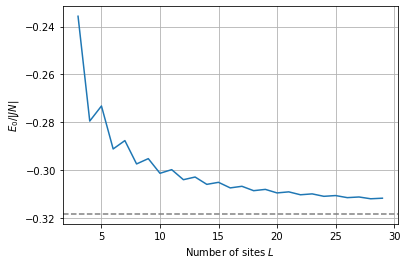

In [79]:
import numpy as np
import matplotlib.pyplot as plt
nsites = np.array(nsites)
reduced_E = np.array(reduced_E)
plt.plot(nsites, reduced_E)
plt.axhline(-1/np.pi,ls='--',color='grey')
plt.xlabel(r'Number of sites $L$')
plt.ylabel(r'$E_{0}/|JN|$')
plt.grid()

## Appendix: Some facts about tenpy models
Reference: https://tenpy.readthedocs.io/en/latest/intro/model.html
### Hamiltonian form and algorithm to run
Different algorithms requires different models. For example:

- The `dmrg` algorithm requires the `MPOModel`, which contains a Hamiltonian written as `MPO`
- The `tebd` (time evolving block decimation) requires the `NearestNeighborModel`, in which the Hamiltonian is written in terms of two-site bond terms for Trotter decomposition.

Tenpy provide interfaces to write down these Hamiltonians simply through the `CouplingModel`

### Hilbert spaces
- Local hilbert space is represented by `Site`, which defines local operators
- Common sites has already been defined by tenpy. For example the Spin, Spin-less, Spin-full fermions, or bosons. They are under `tenpy.networks.site`
- To define some exotic Hilbert spaces, you can create a child of the `Site` class

### Geometry
- Geometry is given by some lattice
- This is given by a `Lattice` class, which contains unit cell of few `Site`
- Examples of predefined lattice are `Chain`, `Ladder` for 1D, and `Square`, `Honeycomb`, and `Kagome` for 2D

### CouplingModel
- The `CouplingModel` is an abstract interface to implement Hamiltonian on a give lattice
- On-site and coupling terms can be added by `add_onsite()` and `add_coupling()` method


### Automatic Hermitian conjugation
- It is recommended to use automatic hermitian conjugation in `add_coupling` to reduce bond dimension and simplify syntax

### Non-uniform coupling
- Non-uniform coupling can be added by feeding in a numpy array